# Formalizing Verbal Theories: A Tutorial by Dialogue

These are the supplementary materials which will build up towards computer simulations of <span style="font-variant: small-caps;">Selecting Invitees (Version 4, 5 and 6)</span>. We explain how the code relates to the computational level formalizations of the main paper and run several sample simulations exploring the models' behaviour.

## Table of contents
* [Setup](#Setup)
 * [Importing libraries](#Importing-libraries)
 * [Helper functions](#Helper-functions)
* [Formalizing selecting invitees variant 4](#Formalizing-selecting-invitees-variant-4)
 * [Simulations for SI4](#Simulations-for-SI4)
 * [Data analysis for SI4](#Data-analysis-for-SI4)

## Setup
We need to import some libraries and define some helper functions.

### Importing libraries
As is common, we need to load libraries for writing our simulation code. Two main libraries are imported: ```mathlib``` for writing simulation code and ```plotly``` for plotting results. Imports may print a lot of information in red, this is normal. If succesful you will see the following output:

```
import coursierapi._
```

```
import $ivy.$

import $ivy.$ 
```

<div class="alert alert-block alert-info">
    <b>Note:</b> If you're using JupyterLab, you have to install jupyterlab-plotly to enable support for rendering Plotly charts. Open up a terminal in JupterLab and run the following command (this may take a while):
    
```
jupyter labextension install jupyterlab-plotly
```
</div>

In [1]:
import coursierapi._

interp.repositories() ++= Seq(
      MavenRepository.of("https://jitpack.io")
  )

import coursierapi._



In [2]:
import $ivy.`com.github.markblokpoel.mathlib::mathlib:master-SNAPSHOT`
import $ivy.`org.plotly-scala::plotly-almond:0.8.1`

import mathlib.set.SetTheory._
import mathlib.probability._
import mathlib.probability.Implicits._

import plotly._
import plotly.element._
import plotly.layout._
import plotly.Almond._

import $ivy.$                                                         

import $ivy.$                                      


import mathlib.set.SetTheory._

import mathlib.probability._

import mathlib.probability.Implicits._


import plotly._

import plotly.element._

import plotly.layout._

import plotly.Almond._

### Helper functions

We define a few helper functions, mainly to generate instances for running the simulations.

We use a simple case class to represent a person who is identified by a name. We assume no two individuals with the same name can exist. We create a helper object for ```Person``` with a predefined list of names from which we can randomly generate a single person using ```Person.random``` or a group of $k$ persons using ```Person.randomGroup(size)```, where ```size```=$k$.

In [3]:
case class Person(name: String) {
  override def toString: String = name
}

case object Person {
    private val names: Set[String] = Set("Nettie","Lester","Brian","Cody","Erik","William","Molly","Joey","Thelma","Edgar","Emanuel","Sergio","Herman","Kelley","Wilfred","Guadalupe","Paula","Sheila","Javier","Kelly","Jason","Gilbert","Harriet","Meghan","Kenneth","Holly","Rose","Lela","Brenda","Constance","Vera","Ramiro","Diana","Charlene","Betty","Michelle","Frederick","Elmer","Byron","Randal","Roderick","Clark","Mathew","Sammy","Colleen","Marian","Tyrone","Keith","Tonya","John","Kayla","Johanna","Dwayne","Antonia","Kerry","Fannie","Nichole","Jeanne","Roberto","Vicky","Jesus","Angela","Fredrick","Fernando","Vivian","Natalie","Johnnie","Monica","Angelica","Anna","Carlos","Marion","Henry","Lawrence","Alexis","Garry","Bernard","Jana","Ernestine","Deborah","Willard","Eileen","Erica","Elvira","Myron","Elena","Ervin","Jeannette","Veronica","Abraham","Lamar","Wanda","Lorraine","Doris","Leigh","Devin","Lindsay","Isabel","Marlene","Betsy")
    
    def random: Person = Person(names.random.getOrElse("Easter Bunny"))
    
    // Returns a set of k random persons.
    def randomGroup(size: Int): Set[Person] = {
        def rg(size: Int, namesLeft: Set[String]): Set[Person] = {
            if(size == 0) Set.empty
            else {
                val newPerson = namesLeft.random
                if(newPerson.isEmpty) Set.empty
                else rg(size - 1, namesLeft - newPerson.get) + Person(newPerson.get)
            }
        }
        
        rg(size, names)
    }
}

defined class Person
defined object Person

A helper function to generate random relationships between pairs of individuals.

In [4]:
object Helpers {
    class PairDoesNotExistException extends NoSuchElementException
    
    /**
     * @param ratio The ratio of likes versus dislikes. Value of 0 means all pairs like eachother,
     * value of 1 means all pairs dislike eachother.
     * @return A function that specifies for each pair in persons if they like eachother or not.
     */
    def genNonReflexiveLikeFunction(persons: Set[Person], ratio: Double = 0.5): (Person, Person) => Boolean = {
        val allPairs = persons.pairs
        
        // Generate a list of true and false (like and dislike) with the specified ratio.
        val likeDislike = List.tabulate(allPairs.size)((i: Int) => {
            if(i <= (ratio * allPairs.size).intValue) false
            else true
        })
        
        // Randomize the order of the like-dislike list.
        val likeDislikeRandomized = scala.util.Random.shuffle(likeDislike)
        
        // Map each pair to a (now random) like-dislike value
        val map = (allPairs zip likeDislikeRandomized).toMap
        
        // Define a function f that takes two persons and returns a Boolean.
        def f(person1: Person, person2: Person): Boolean = {
            if(map.contains((person1, person2))) map((person1, person2))
            else throw new PairDoesNotExistException()
        }
        
        // Return the function
        f
    }
}

defined object Helpers

## Formalizing selecting invitees variant 4

We recap the formalism: 

<span style="font-variant: small-caps;">Selecting Invitees (Version 4)</span>

*Input:* A set $P$, subsets $L\subseteq P$ and $D\subseteq P$ with $L\cap D=\varnothing$ and $L\cup D=P$, a function $like:P\times P\rightarrow \{true,false\}$, and a threshold value $k$.

*Output:* A subset $G\subseteq P$ such that $|G\cap D|\leq k$ and $|X|+|G|$ is maximized (where $X=\left\{p_i,p_j\in G ~\middle|~like(p_i,p_j)=true \wedge i\neq j\right\}$).

Since the formalism is out of context, let's explain what each variable represents. We will also use more verbose names in our simulation code for clarity. Note that some variables used in the output do not have corresponding labels in the code. These will be defined implicitly.

| Math | Scala | Description |
| --- | --- | --- |
| $P$ | ```persons``` | Set of persons from which to select invitees. |
| $L$ | ```personsLiked``` | Subset of persons that is liked. |
| $D$ | ```personsDisliked``` | Subset of persons that is disliked. |
| $like$ | ```like``` | Function that captures if two persons like each other or not. |
| $k$ | ```k``` | Value that states how many of the invited persons at most can be disliked. |
| $G$ | n.a. | Set of invited persons. |
| $X$ | n.a. | Set of all pairs of persons that like each other. |

In [6]:
def selectingInviteesV4(persons: Set[Person],
                        personsLiked: Set[Person],
                        personsDisliked: Set[Person],
                        like: (Person, Person) => Boolean,
                        k: Int): Set[Person] = {
    // Specify requirements. Selecting Invitees V4 is undefined if requirements are not met.
    requirement(personsLiked subsetOf persons,
                "L must be a subset of P")
    requirement(personsDisliked subsetOf persons,
                "D must be a subset of P")
    requirement((personsLiked intersect personsDisliked).isEmpty,
                "intersection between L and D must be emtpy")
    requirement((personsLiked union personsDisliked) == persons,
                "union of L and D must equal P")
    
    // Specify what makes a valid (sub)set of invitees:
    def atMostKDislikes(invitees: Set[Person]): Boolean = {
        // |G /\ D| <= k
        (invitees /\ personsDisliked).size <= k
    }
    
    // Specify the optimality condition:
    def xg(invitees: Set[Person]): Int = {
        // |X|
        val x = invitees.uniquePairs // From all pairs of invitees,
                .build(like.tupled)  // select all pairs that like each other,
                .size                // and count them.
        // |G|
        val g = invitees.size        // Count the number of total invitees.
        
        x + g
    }
    
    val invitees = powerset(persons)  // From all possible subsets of persons,
        .build(atMostKDislikes)       // select subsets that contain at most k disliked persons,
        .argMax(xg)                   // then select the subsets that maximize the optimality condition.
    
    // If more than one solution exists, return one at random. Always 1 solution must exist,
    // because the empty set is a valid solution. Hence, we can assume random does not
    // return None and 'get' the value.
    invitees.random.get 
}

defined function selectingInviteesV4

### Simulations for SI4
Now that we have written simulation code, we can run some test simulations. To do so, we first create a group of random persons:

In [7]:
val group = Person.randomGroup(10)

group: Set[Person] = HashSet(
  Person("Keith"),
  Person("Colleen"),
  Person("Joey"),
  Person("Dwayne"),
  Person("Betsy"),
  Person("Brian"),
  Person("Guadalupe"),
  Person("Lester"),
  Person("Angelica"),
  Person("Michelle")
)

We also need to specify which of these persons are liked $L$ and disliked $D$ by the host. We do this by splitting the group randomly:

In [8]:
val (personsLiked, personsDisliked) = group.splitAt(scala.util.Random.nextInt(group.size))

personsLiked: Set[Person] = HashSet(Person("Keith"))
personsDisliked: Set[Person] = HashSet(
  Person("Colleen"),
  Person("Joey"),
  Person("Dwayne"),
  Person("Betsy"),
  Person("Brian"),
  Person("Guadalupe"),
  Person("Lester"),
  Person("Angelica"),
  Person("Michelle")
)

Finally, we need to specify the like-dislike relationships between all pairs of persons. We can use the helper function to do this. Here, we use ```Helpers.genNonReflexiveLikeFunction``` which incorporate the assumption that if $A$ likes $B$ then $B$ can dislike $A$, i.e., $like$ is not reflexive.

In [9]:
def like = Helpers.genNonReflexiveLikeFunction(group, ratio = 0.5)

defined function like

We can now simulate <span style="font-variant: small-caps;">Selecting Invitees (Version 4)</span> by running the following function for any value of $k$. If you regenerate the group and their relations, you may get different results. You may even get different results for the same input if multiple sets of invitees are equally (maximally) good: 

In [10]:
selectingInviteesV4(group, personsLiked, personsDisliked, like, k = 6)

res9: Set[Person] = HashSet(
  Person("Keith"),
  Person("Lester"),
  Person("Colleen"),
  Person("Joey"),
  Person("Dwayne"),
  Person("Betsy"),
  Person("Brian")
)

If we vary parameter $k$, we can plot e.g., group size relative to $k$. To collect model behaviour without introducing confounds, we should also sample multiple randomized groups with different relationships. Let's first create our virtual participants. We can generate as many samples as we like:

In [11]:
val sampleSize = 50
val groupSize = 10
val ratio = 0.5 // We use a fixed ratio between like and dislike, but feel free to change it.

// Generate sampleSize groups of size groupSize
val groups = List.tabulate(sampleSize)(_ => Person.randomGroup(groupSize))

sampleSize: Int = 50
groupSize: Int = 10
ratio: Double = 0.5
groups: List[Set[Person]] = List(
  HashSet(
    Person("Angela"),
    Person("Erik"),
    Person("Isabel"),
    Person("Eileen"),
    Person("Constance"),
    Person("Wanda"),
    Person("Kelley"),
    Person("Paula"),
    Person("Monica"),
    Person("Emanuel")
  ),
  HashSet(
    Person("Sammy"),
    Person("Marlene"),
    Person("Javier"),
    Person("Brenda"),
    Person("Jason"),
    Person("Lela"),
    Person("Vicky"),
    Person("Paula"),
    Person("Eileen"),
    Person("Colleen")
  ),
  HashSet(
    Person("Johnnie"),
    Person("Wilfred"),
    Person("Wanda"),
    Person("Randal"),
    Person("Herman"),
    Person("Vera"),
    Person("Leigh"),
    Person("Brenda"),
    Person("Paula"),
    Person("Sergio")
  ),
  HashSet(
    Person("Devin"),
...

The code below runs the simulation for each ```group``` in ```groups``` and for all possible values of ```k```. The loop yields (returns) the data in a simple case class structure:

In [12]:
case class SI4Data(group: Set[Person],
                   personsLiked: Set[Person],
                   personsDisliked: Set[Person],
                   like: (Person, Person) => Boolean,
                   k: Int,
                   invitees: Set[Person])

val data = for(group <- groups; k <- 0 to groupSize) yield {
    // Split the group at random for the host to like or dislike
    val (personsLiked, personsDisliked) = group.splitAt(scala.util.Random.nextInt(group.size))
    def like = Helpers.genNonReflexiveLikeFunction(group, ratio)
    // Run the simulation for this group and this like relationship
    val invitees = selectingInviteesV4(group, personsLiked, personsDisliked, like, k)
    // Return the data
    SI4Data(group, personsLiked, personsDisliked, like, k, invitees)
}

defined class SI4Data
data: List[SI4Data] = List(
  SI4Data(
    HashSet(
      Person("Angela"),
      Person("Erik"),
      Person("Isabel"),
      Person("Eileen"),
      Person("Constance"),
      Person("Wanda"),
      Person("Kelley"),
      Person("Paula"),
      Person("Monica"),
      Person("Emanuel")
    ),
    HashSet(Person("Angela")),
    HashSet(
      Person("Erik"),
      Person("Isabel"),
      Person("Eileen"),
      Person("Constance"),
      Person("Wanda"),
      Person("Kelley"),
      Person("Paula"),
      Person("Monica"),
      Person("Emanuel")
    ),
    ammonite.$sess.cmd3$Helper$Helpers$$$Lambda$2710/255674506@736e3ddf,
    0,
    HashSet(Person("Angela"))
  ),
  SI4Data(
    HashSet(
      Person("Angela"),
      Person("Erik"),
      Person("Isabel"),
      Person("Eileen"),
      Person("Constance"),
      Person("Wanda"),
      Person("Kelley"),
...

### Data analysis for SI4
Now that we have our data, we can visualize it.

In [13]:
val kData = data.map(_.k) // Extract the k values for each data point.
val nrInviteesData = data.map(_.invitees.size) // Extract the invitees for each data point and compute group size.
val likesNormalizedData = data.map(datapoint => {
    val pairs = datapoint.invitees.pairs
    val likeDislikes = datapoint.invitees.pairs.toList.map(datapoint.like.tupled)
    likeDislikes.count(_ == true) / pairs.size.doubleValue
})
val ldRatioData = data.map(datapoint => {
    val pairs = datapoint.invitees.pairs
    val likeDislikes = datapoint.invitees.pairs.toList.map(datapoint.like.tupled)
    val likes = likeDislikes.count(_ == true)
    val dislikes = likeDislikes.count(_ == false)
    likes.doubleValue / dislikes.doubleValue
})

kData: List[Int] = List(
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  0,
  1,
  2,
  3,
  4,
...
nrInviteesData: List[Int] = List(
  1,
  8,
  4,
  8,
  4,
  10,
  9,
  9,
  10,
  10,
  10,
  2,
  9,
  9,
  10,
  10,
  9,
  8,
  10,
  8,
  10,
  10,
  6,
  4,
  5,
  10,
  10,
  5,
  7,
  10,
  10,
  10,
  10,
  8,
  1,
  7,
  6,
  9,
...
likesNormalizedData: List[Double] = List(
  0.0,
  0.59375,
  0.6875,
  0.546875,
  0.625,
  0.49,
  0.49382716049382713,
  0.49382716049382713,
  0.49,
  0.49,
  0.49,
  0.25,
  0.5185185185185185,
  0.48148148148148145,
  0.49,
  0.49,
  0.4691358024691358,
  0.453125,
  0.49,
  0.484375,
  0.49,
  0.49,
  0.4722222222222222,
  0.4375,
  0.4,
  0.49,
  0.49,
  0.52,
  0.5714285714285714,
  0.49,
  0.49,
  0.49,
  0.49,
  0.421875,
  1.0,
  0.46938775510204084,
  0.5277777777777778,
  0.5185185185185185,
...
ldRatioData: List[Do

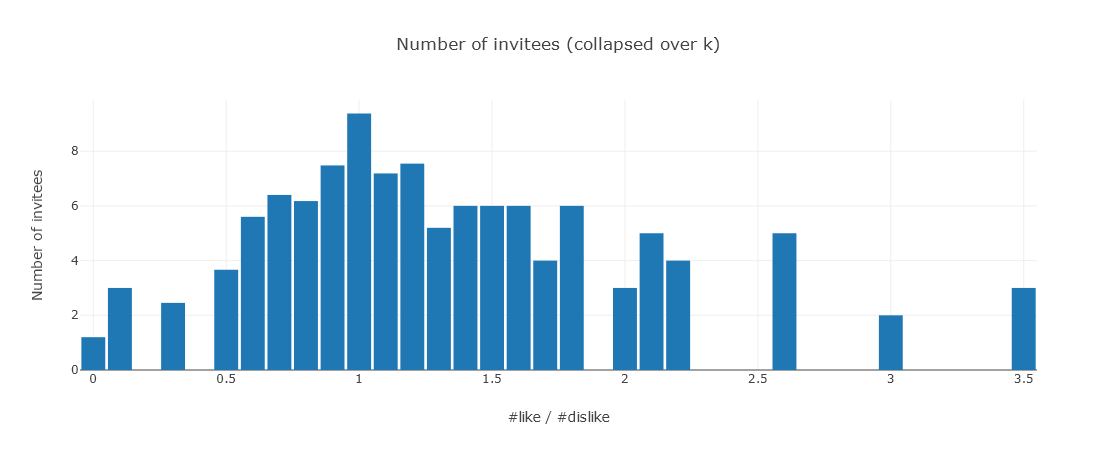

res13: String = "plot-4f769e17-37c5-4a28-907a-327d9ef3c2eb"

In [14]:
Histogram()
.withX(ldRatioData)
.withY(nrInviteesData)
.withHistfunc(HistFunc.Average)
.plot(Layout()
      .withTitle("Number of invitees (collapsed over k)")
      .withXaxis(Axis()
                 .withTitle("#like / #dislike")
                 .withShowgrid(true)
      )
      .withYaxis(Axis()
                 .withTitle("Number of invitees")
                 .withShowgrid(true)
      )
      .withBargap(.1)
)

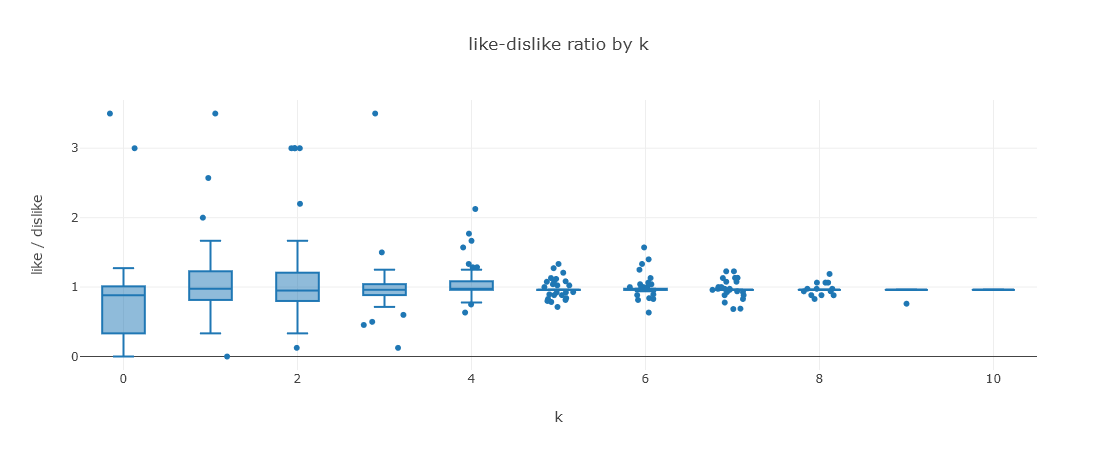

res14: String = "plot-893f35fe-c461-4f53-88c9-f16e8fc6be7f"

In [15]:
Box()
.withX(kData)
.withY(ldRatioData)
.withJitter(1.0)
.plot(Layout()
     .withTitle("like-dislike ratio by k")
     .withXaxis(Axis()
                .withTitle("k")
                .withShowgrid(true)
     )
     .withYaxis(Axis()
                .withTitle("like / dislike")
                .withShowgrid(true)
     )
)

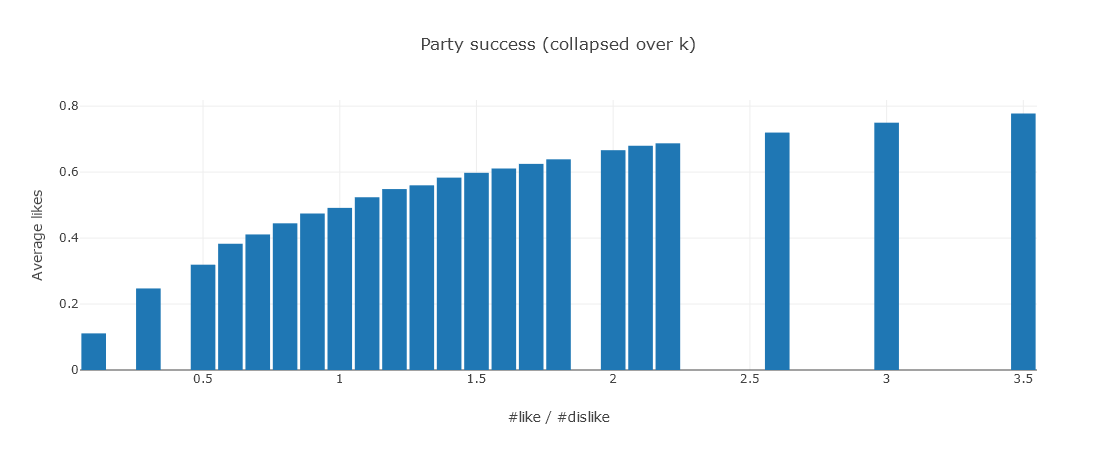

res15: String = "plot-fbc91425-e622-4b79-85af-3ea61372aa0d"

In [16]:
Histogram()
.withX(ldRatioData)
.withY(likesNormalizedData)
.withHistfunc(HistFunc.Average)
.plot(Layout()
      .withTitle("Party success (collapsed over k)")
      .withXaxis(Axis()
                 .withTitle("#like / #dislike")
                 .withShowgrid(true)
      )
      .withYaxis(Axis()
                 .withTitle("Average likes")
                 .withShowgrid(true)
      )
      .withBargap(.1)
)